In [1]:
# Data Manipulation 
import numpy as np
import pandas as pd
import gc
import time
import pickle

# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns

# Feature Encoding
#from sklearn.preprocessing import OneHotEncoder

# Machine learning 

from sklearn import preprocessing, metrics, model_selection, ensemble, pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier, plot_importance

# Grid and Random Search

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Metrics
#from sklearn.metrics import roc_curve, auc, roc_auc_score, roc_curve #confusion_matrix

# Plot the Figures Inline
%matplotlib inline

# Préparation des données
## Nettoyage et ingenierie des donnees

In [2]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [3]:
# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv('application_train.csv', nrows= num_rows)
    test_df = pd.read_csv('application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df)
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    gc.collect()
    return df

In [4]:
# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('bureau.csv', nrows = num_rows)
    bb = pd.read_csv('bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

In [5]:
# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

In [6]:
# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg


In [7]:
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

In [8]:
# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

In [9]:
num_rows = 10000

df = application_train_test(num_rows)

bureau = bureau_and_balance(num_rows)
print("Bureau df shape:", bureau.shape)
df = df.join(bureau, how='left', on='SK_ID_CURR')
del bureau
gc.collect()

prev = previous_applications(num_rows)
print("Previous applications df shape:", prev.shape)
df = df.join(prev, how='left', on='SK_ID_CURR')
del prev
gc.collect()

pos = pos_cash(num_rows)
print("Pos-cash balance df shape:", pos.shape)
df = df.join(pos, how='left', on='SK_ID_CURR')
del pos
gc.collect()

ins = installments_payments(num_rows)
print("Installments payments df shape:", ins.shape)
df = df.join(ins, how='left', on='SK_ID_CURR')
del ins
gc.collect()

cc = credit_card_balance(num_rows)
print("Credit card balance df shape:", cc.shape)
df = df.join(cc, how='left', on='SK_ID_CURR')
del cc
gc.collect()

Train samples: 10000, test samples: 10000
Bureau df shape: (2011, 108)
Previous applications df shape: (9734, 242)
Pos-cash balance df shape: (9494, 15)
Installments payments df shape: (8893, 26)
Credit card balance df shape: (9520, 131)


0

## Imputation des valeurs manquantes

In [10]:
# Removing columns with no information
y = df['TARGET']
X = df.drop('TARGET', axis =1)
X = X.dropna(axis=1, how='all')

# Processing infinite values 
X = X.replace([-np.inf, np.inf], np.nan)

# Imputing columns with partial information
X = X.fillna(X.mean())
df = pd.concat([y, X], axis=1)

## Processing des données

In [11]:
# Splitting the Training and Test data sets
df_train = df[df['TARGET'].notnull()]
df_y_train =  df_train['TARGET']
df_X_train = df_train.drop('TARGET', axis =1)

# Preprocessing the Training data
std_scale = preprocessing.StandardScaler().fit(df_X_train) 

X_train_std = std_scale.transform(df_X_train)

# Splitting the processed Training data into train and test data sets
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_train_std, 
                                                                    df_y_train, 
                                                                    stratify = df_y_train,
                                                                    test_size = 0.3)

# Creating 5 Stratified Folds
skf = model_selection.StratifiedKFold(n_splits=5)

# Modelisation
* Baseline = dummyClassifier
* Logistic Regression
* Gaussian Naive Bayes
* Decision Tree
* Random Forest
* LightGBM

In [12]:
# Function that runs the requested algorithm and returns the accuracy metrics for RandomizedSearch

def fit_rs_ml_algo(algo, param_dist, X_train, y_train, X_test, y_test, cv):
    
    start_time = time.time()
    
    model = model_selection.RandomizedSearchCV(algo,
                                               n_jobs=-1,
                                               param_distributions=param_dist,
                                               n_iter=10,
                                               cv=cv,
                                               scoring = 'roc_auc')
    
    model.fit(X_train, y_train)
    
    best_param = model.best_params_
    
    probs = model.predict_proba(X_test)[:,1]
    
    auc = round(metrics.roc_auc_score(y_test, probs) * 100, 1)
    
    algo_time = round((time.time() - start_time), 1)
    
    return best_param, auc, probs, algo_time

## Baseline

In [13]:
# Dummy Classifier

param_dist = {'strategy':['stratified','most_frequent','constant']}

best_param_dum, auc_dum, probs_dum, dum_time = fit_rs_ml_algo(DummyClassifier(strategy='most_frequent'),
                                                                                            param_dist,
                                                                                            X_train,
                                                                                            y_train,
                                                                                            X_test,
                                                                                            y_test,
                                                                                            skf)
print('Best parameter: %s' % best_param_dum)
print('AUC:            %s' % auc_dum)
print('Run Time:       %s' % dum_time, 'seconds')

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Best parameter: {'strategy': 'most_frequent'}
AUC:            50.0
Run Time:       1.2 seconds


## Regression Logistique

In [14]:
# Logistic Regression
param_dist = {'penalty': ['l2', 'l1'], 
              'C': np.logspace(-5, 5, 11)}

best_param_reg, auc_reg, probs_reg, reg_time = fit_rs_ml_algo(LogisticRegression(n_jobs = -1),
                                                                                            param_dist,
                                                                                            X_train,
                                                                                            y_train,
                                                                                            X_test,
                                                                                            y_test,
                                                                                            skf)
print('Best parameter: %s' % best_param_reg)
print('AUC:            %s' % auc_reg)
print('Run Time:       %s' % reg_time, 'seconds')

Best parameter: {'penalty': 'l2', 'C': 0.01}
AUC:            71.4
Run Time:       8.7 seconds


## Arbre de décision

In [15]:
# Decision Tree Classifier
param_dist = {'max_depth': [2, 5, 10, 20, 50, 100],
             'criterion': ['gini', 'entropy']}

best_param_dtc, auc_dtc, probs_dtc, dtc_time = fit_rs_ml_algo(DecisionTreeClassifier(),
                                                                                            param_dist,
                                                                                            X_train,
                                                                                            y_train,
                                                                                            X_test,
                                                                                            y_test,
                                                                                            skf)
print('Best parameter: %s' % best_param_dtc)
print('AUC:            %s' % auc_dtc)
print('Run Time:       %s' % dtc_time, 'seconds')

Best parameter: {'max_depth': 5, 'criterion': 'entropy'}
AUC:            69.7
Run Time:       5.0 seconds


## Foret alleatoire

In [16]:
# Random Forest Classifier
param_dist = {'max_depth': [2, 5, 10, 20, 50, 100],
             'criterion': ['gini', 'entropy']}

best_param_rfc, auc_rfc, probs_rfc, rfc_time = fit_rs_ml_algo(RandomForestClassifier(),
                                                                                            param_dist,
                                                                                            X_train,
                                                                                            y_train,
                                                                                            X_test,
                                                                                            y_test,
                                                                                            skf)
print('Best parameter: %s' % best_param_rfc)
print('AUC:            %s' % auc_rfc)
print('Run Time:       %s' % rfc_time, 'seconds')

/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best parameter: {'max_depth': 5, 'criterion': 'entropy'}
AUC:            73.5
Run Time:       14.0 seconds


## Light GBM

In [17]:
# Light GBM

param_dist = {'max_depth': [2, 5, 10, 20, 50, 100],
             'num_leaves': [2, 5, 10, 20, 50, 100]}

best_param_lgb, auc_lgb, probs_lgb, lgb_time = fit_rs_ml_algo(LGBMClassifier(),
                                                                                            param_dist,
                                                                                            X_train,
                                                                                            y_train,
                                                                                            X_test,
                                                                                            y_test,
                                                                                            skf)
print('Best parameter: %s' % best_param_lgb)
print('AUC:            %s' % auc_lgb)
print('Run Time:       %s' % lgb_time, 'seconds')

/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best parameter: {'num_leaves': 20, 'max_depth': 2}
AUC:            76.9
Run Time:       7.7 seconds


## Classement des résultats

In [18]:
models = pd.DataFrame({
    'Model': ['Dummy',
              'Logistic Regression',
              'Decision Tree',
              'Random Forest', 
              'Light GBM'
             ],
    'AUC score': [auc_dum,
                  auc_reg,
                  auc_dtc,
                  auc_rfc,
                  auc_lgb
                 ],
    'Run Time (in s.)': [dum_time,
                  reg_time,
                  dtc_time,
                  rfc_time,
                  lgb_time
                ]
    })
models.sort_values(by='AUC score', ascending=False)

,Model,AUC score,Run Time (in s.)
4,Light GBM,76.9,7.7
3,Random Forest,73.5,14.0
1,Logistic Regression,71.4,8.7
2,Decision Tree,69.7,5.0
0,Dummy,50.0,1.2


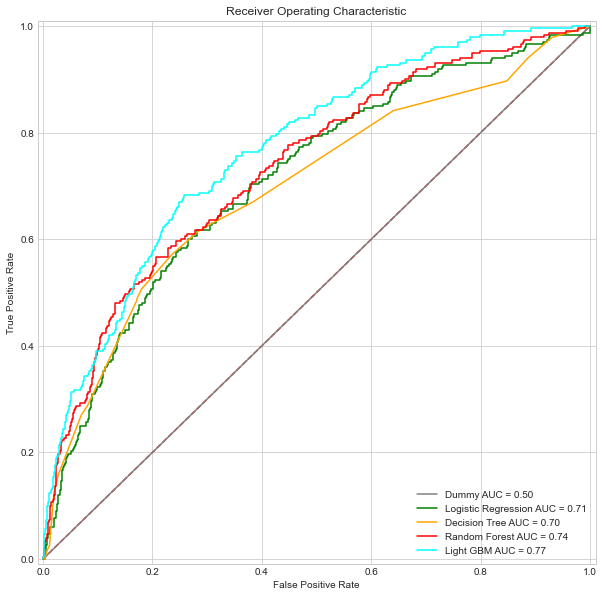

In [19]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(10,10)) 

models = ['Dummy',
          'Logistic Regression',
          'Decision Tree',
          'Random Forest',
          'Light GBM']

probs = [probs_dum,
         probs_reg,
         probs_dtc,
         probs_rfc,
         probs_lgb]


colors = [
    'grey',
    'green',
    'orange',
    'red',
    'cyan']
    
plt.title('Receiver Operating Characteristic')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

def plot_roc_curves(y_test, prob, model):
    fpr, tpr, threshold = metrics.roc_curve(y_test, prob)
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, 'b', label = model + ' AUC = %0.2f' % roc_auc, color=colors[i])
    plt.legend(loc = 'lower right')
    
for i, model in list(enumerate(models)):
    plot_roc_curves(y_test, probs[i], models[i])
    
plt.show()

# Passage à l'échelle
## Reprise de l'entrainement sur tout application_train

In [20]:
num_rows = None

df = application_train_test(num_rows)

bureau = bureau_and_balance(num_rows)
print("Bureau df shape:", bureau.shape)
df = df.join(bureau, how='left', on='SK_ID_CURR')
del bureau
gc.collect()

prev = previous_applications(num_rows)
print("Previous applications df shape:", prev.shape)
df = df.join(prev, how='left', on='SK_ID_CURR')
del prev
gc.collect()

pos = pos_cash(num_rows)
print("Pos-cash balance df shape:", pos.shape)
df = df.join(pos, how='left', on='SK_ID_CURR')
del pos
gc.collect()

ins = installments_payments(num_rows)
print("Installments payments df shape:", ins.shape)
df = df.join(ins, how='left', on='SK_ID_CURR')
del ins
gc.collect()

cc = credit_card_balance(num_rows)
print("Credit card balance df shape:", cc.shape)
df = df.join(cc, how='left', on='SK_ID_CURR')
del cc
gc.collect()

Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 116)
Previous applications df shape: (338857, 249)
Pos-cash balance df shape: (337252, 18)
Installments payments df shape: (339587, 26)
Credit card balance df shape: (103558, 141)


0

In [21]:
# Removing columns with no information
y = df['TARGET']
X = df.drop('TARGET', axis =1)
X = X.dropna(axis=1, how='all')

# Processing infinite values 
X = X.replace([-np.inf, np.inf], np.nan)

# Imputing columns with partial information
X = X.fillna(X.mean())
df = pd.concat([y, X], axis=1)

# Splitting the Training and Test data sets
df_train = df[df['TARGET'].notnull()]
df_test = df[df['TARGET'].isnull()]
df_y_train =  df_train['TARGET']
df_X_train = df_train.drop('TARGET', axis =1)

# Preprocessing the Training data
std_scale = preprocessing.StandardScaler().fit(df_X_train) 

X_train_std = std_scale.transform(df_X_train)

# Splitting the processed Training data into train and test data sets
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_train_std, 
                                                                    df_y_train, 
                                                                    stratify = df_y_train,
                                                                    test_size = 0.3)

# Creating 5 Stratified Folds
skf = model_selection.StratifiedKFold(n_splits=5)

## Export des données transformées

In [22]:
# Export Processed Train and Test data to csv datafiles
df_train.to_csv(r'train_data.csv')
df_test.to_csv(r'test_data.csv')

## Optimisation

In [23]:
# Function that runs the requested algorithm and returns the accuracy metrics for GridSearch

def fit_gs_ml_algo(algo, param_grid, X_train, y_train, X_test, y_test, cv):
    
    start_time = time.time()
    
    model = model_selection.GridSearchCV(algo,
                                         param_grid,
                                         cv = cv,
                                         scoring = 'roc_auc')
    
    model.fit(X_train, y_train)
    
    best_param = model.best_params_
    
    probs = model.predict_proba(X_test)[:,1]
    
    auc = round(metrics.roc_auc_score(y_test, probs) * 100, 2)

    algo_time = round((time.time() - start_time), 1)
    
    return best_param, auc, probs, algo_time

In [24]:
# Optimised Light GBM - round #1
param_grid = {'max_depth': [2, 5, 10, 20, 50, 100],
             'num_leaves': [2, 5, 10, 20, 50, 100],
             }

best_param_opt1, auc_opt1, probs_opt1, opt1_time = fit_gs_ml_algo(LGBMClassifier(),
                                                                  param_grid,
                                                                  X_train,
                                                                  y_train,
                                                                  X_test,
                                                                  y_test,
                                                                  skf)
print('Best parameter: %s' % best_param_opt1)
print('AUC:            %s' % auc_opt1)
print('Run Time:       %s' % opt1_time, 'seconds')

Best parameter: {'max_depth': 20, 'num_leaves': 20}
AUC:            77.88
Run Time:       1985.2 seconds


In [26]:
# Optimised Light GBM - round #2
param_grid = {'max_depth': [11, 15, 20, 26, 33],
             'num_leaves': [11, 15, 20, 26, 33]
             }

best_param_opt2, auc_opt2, probs_opt2, opt2_time = fit_gs_ml_algo(LGBMClassifier(),
                                                                  param_grid,
                                                                  X_train,
                                                                  y_train,
                                                                  X_test,
                                                                  y_test,
                                                                  skf)
print('Best parameter: %s' % best_param_opt2)
print('AUC:            %s' % auc_opt2)
print('Run Time:       %s' % opt2_time, 'seconds')

Best parameter: {'max_depth': 15, 'num_leaves': 20}
AUC:            77.88
Run Time:       1665.6 seconds


In [27]:
models = pd.DataFrame({
    'Model': [ 'Sample RdCV', 'Full GsCV1', 'Full GsCV2'],
    'AUC': [auc_lgb, auc_opt1, auc_opt2],
    'Time': [lgb_time, opt1_time, opt2_time]
    })
models.sort_values(by='AUC', ascending=False)

,Model,AUC,Time
1,Full GsCV1,77.88,1985.2
2,Full GsCV2,77.88,1665.6
0,Sample RdCV,76.90,7.7


## Calcul du seuil

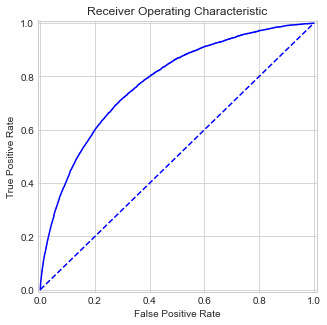

In [29]:
fpr_opt, tpr_opt, threshold_opt = metrics.roc_curve(y_test, probs_opt2)

plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(5,5)) 
plt.title('Receiver Operating Characteristic')
plt.plot([0, 1], [0, 1],'b--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.plot(fpr_opt, tpr_opt, 'b')
plt.show()

In [30]:
# ordering classes by threshold
order = np.argsort(probs_opt2)
y_true = np.asarray(y_test)[order]
y_score = probs_opt2

In [31]:
# The thresholds to consider are just the values of score, and 0 (accept everything)
thresholds = np.insert(y_score[order],0,0)
# TP = [sum(y_true)] # Number of True Positives (For Threshold = 0 => We accept everything => TP[0] = # of postive in true y)
# FP = [sum(1-y_true)] # Number of True Positives (For Threshold = 0 => We accept everything => TP[0] = # of postive in true y)
TN = [0] # Number of True Negatives (For Threshold = 0 => We accept everything => we don't have negatives !)
FN = [0] # Number of True Negatives (For Threshold = 0 => We accept everything => we don't have negatives !)

for i in range(1, thresholds.size) : # "-1" because the last threshold
    # At this step, we stop predicting y_score[i-1] as True, but as False.... what y_true value say about it ?
    # if y_true was True, that step was a mistake !
#    TP.append(TP[-1] - int(y_true[i-1]))
    FN.append(FN[-1] + int(y_true[i-1]))
    # if y_true was False, that step was good !
#    FP.append(FP[-1] - int(1-y_true[i-1]))
    TN.append(TN[-1] + int(1-y_true[i-1]))

#TP = np.asarray(TP, dtype=np.int_)
#FP = np.asarray(FP, dtype=np.int_)
TN = np.asarray(TN, dtype=np.int_)
FN = np.asarray(FN, dtype=np.int_)

margins = 10*TN - 100*FN

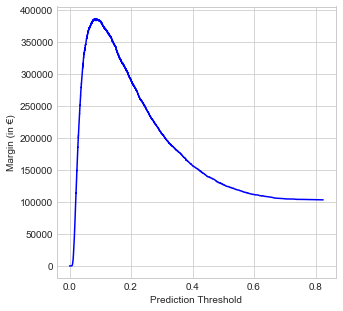

In [32]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(5,5)) 

plt.plot(thresholds, margins, 'b')
plt.ylabel('Margin (in €)')
plt.xlabel('Prediction Threshold')    
plt.show()

In [33]:
max_margins = np.argmax(margins)
print('Optimal Threshold:', thresholds[max_margins].round(3))

Optimal Threshold: 0.082


## Importance des variables

In [34]:
model_opt = LGBMClassifier(max_depth= 8, 
                           num_leaves= 26)

model_opt.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=8,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=26, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

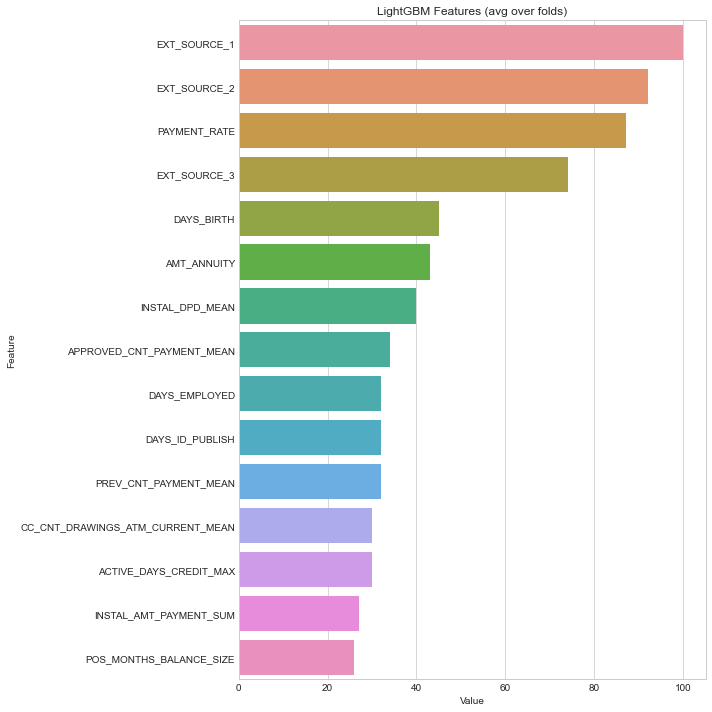

In [35]:
# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(model_opt.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(10, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[:15])
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

# Exports du modele et du seuil

In [36]:
# export optimized model and threshold

import joblib

joblib.dump(model_opt,
            'trained_model.joblib')

joblib.dump(thresholds[max_margins],
            'trained_model_threshold.joblib')

['trained_model_threshold.joblib']

# Déploiement du modele avec MLflow

In [37]:
# extract model's signature
from mlflow.models.signature import infer_signature

signature = infer_signature(X_train, model_opt.predict(X_train))

In [41]:
import mlflow.sklearn

In [43]:
# save model in Github local repository
# path_dir='/Users/guillaumevial/GitHub/P7_dashboard/ml_flow_api/'

mlflow.sklearn.save_model(model_opt, 
                          'mlflow_model',
                          signature=signature)